<a href="https://colab.research.google.com/github/stefsyrsiri/synthetic-image-detection/blob/eval/report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting AI-Generated Synthetic Images

The boom of AI-powered content generation and increasing interest in the research field of Deep Learning has led to widely accessible (and trending) tools that can produce content of any kind: text, image, audio, and video. While AI isn't new, the the availability of powerful low-code generative AI applications to the public is. AI-generated content can often be indistinguishable from its authentic counterparts, posing a threat to the credibility of digital media. The underlying dangers of the misuse of GenAI have already come to surface with deepfakes, voice cloning, fakes news, disinformation, identity theft and various types of scams. In fact, a survey conducted by Microsoft in 2023 shows that 71% of respondents are worried about AI scams.

In this report, we focus on image generation, which can have multiple societal effects, especially on people not familiar with this kind of technology. Our task is to train a neural network to identify whether an image is real or AI-generated.



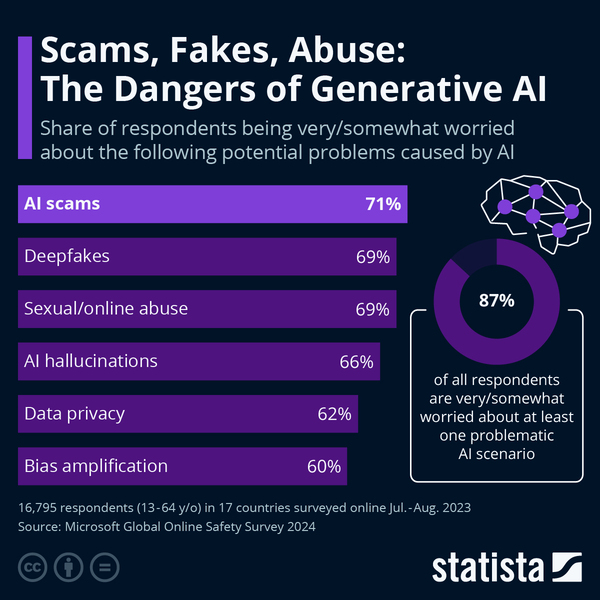

In [ ]:
CUDA_LAUNCH_BLOCKING="1"

# Import packages and custom functions
import random
import os
import sys
from PIL import Image
import time
import pandas as pd
import numpy as np
import tempfile
from tqdm.auto import tqdm
from typing import Dict, List, Tuple


# PyTorch and CV
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import InterpolationMode, v2
import torchvision.transforms.v2 as v2_transforms
import cv2
!pip -q install torchinfo
import torchinfo
!pip -q install gradio
import gradio as gr
from torch.utils.data import DataLoader, TensorDataset

# Visualization and Evaluation
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

# Classes
!git clone https://github.com/stefsyrsiri/synthetic-image-detection.git
sys.path.append('/content/synthetic-image-detection')
from functions import *

## Dataset

The dataset we're using to train our classifier is **[CIFAKE: Real and AI-Generated Synthetic Images](https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images)**, which can be found on Kaggle.

CIFAKE is a comprehensive collection of 60,000 synthetically-generated images and 60,000 real images (collected from CIFAR-10). The dataset contains two classes, labelled as "REAL" and "FAKE".

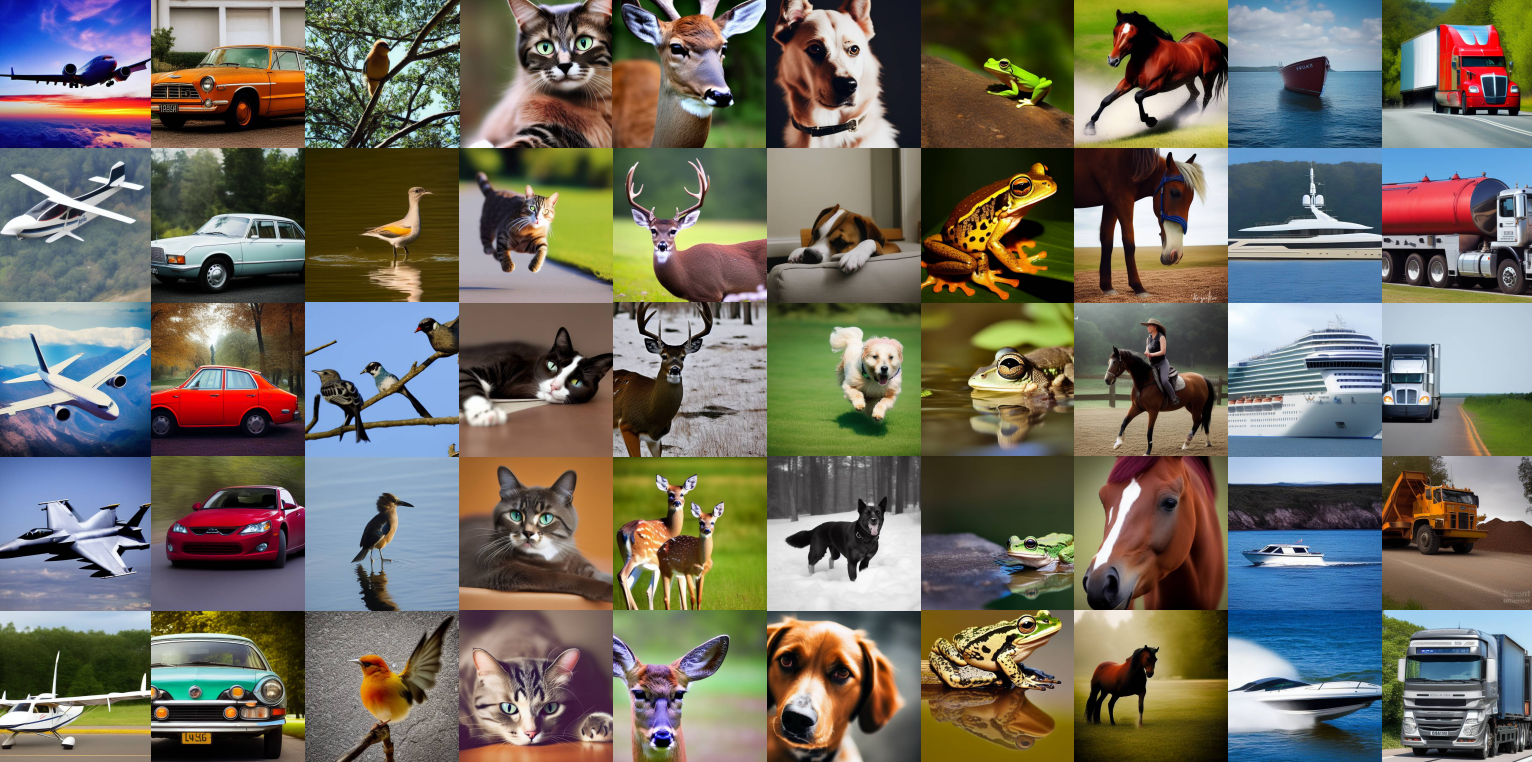

For **REAL**, the images were collected from Krizhevsky & Hinton's CIFAR-10 dataset, which originally has 10 classes:


*   airplane
*   automobile
*   bird
*   cat
*   deer
*   dog
*   frog
*   horse
*   ship
*   truck



For the **FAKE** images, the equivalent of CIFAR-10 was generated with Stable Diffusion version 1.4

There are 100,000 images for training (50k per class) and 20,000 for testing (10k per class). Since the training an test sets have 50% of each class, there is no class imbalance that needs to be taken care of for our binary classification task.

In [20]:
# Download CIFAKE dataset
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

# Unzip downloaded dataset (can be found in the Files on the left)
!unzip -q cifake-real-and-ai-generated-synthetic-images.zip

Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
cifake-real-and-ai-generated-synthetic-images.zip: Skipping, found more recently modified local copy (use --force to force download)
replace test/FAKE/0 (10).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

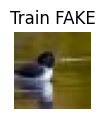

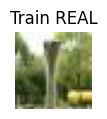

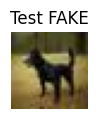

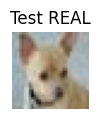

In [21]:
# Paths to the dataset
train_fake_path = './train/FAKE'
train_real_path = './train/REAL'
test_fake_path = './test/FAKE'
test_real_path = './test/REAL'

# Function to display an image
def show_image(title, path):
    image_files = os.listdir(path)
    img_path = os.path.join(path, image_files[6])  # Just take the first image for now
    img = Image.open(img_path)

    plt.figure(figsize=(1, 1))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')  # Hide the axis
    plt.show()

# Show one image from each category
show_image('Train FAKE', train_fake_path)
show_image('Train REAL', train_real_path)
show_image('Test FAKE', test_fake_path)
show_image('Test REAL', test_real_path)

In [ ]:
# Our classes' labels
print(f"Training labels: {np.asarray(os.listdir('train'))}")
print(f"Test labels: {np.asarray(os.listdir('test'))}")

Training labels: ['REAL' 'FAKE']
Test labels: ['REAL' 'FAKE']


In [22]:
# Create the training and test datasets with ImageFolder class from PyTorch
# Training set
train_set = datasets.ImageFolder(root='train') # 'train' is the name of the folder (also its path)
print(f"Training set: {len(train_set):,}")

# Test set
test_set  = datasets.ImageFolder(root='test')
print(f"Test set: {len(test_set):,}")

Training set: 100,000
Test set: 20,000


In [23]:
# Define the path to your CIFAKE dataset (update this with the path to your dataset)
train_fake_path = 'train'

# Define the transformations (if any)
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the dataset with ImageFolder or appropriate method for CIFAKE
try:
    train_set = datasets.ImageFolder(root=train_fake_path, transform=transform)

    # Get an image and label from the dataset
    img, label = train_set[0]  # Load the first image in the dataset

    # Ensure 'img' is a PIL image for the transformation to work
    img = transforms.ToPILImage()(img)

    # Get the size of the image (width, height)
    image_size = img.size

    print("Image size (width, height):", image_size)

    # To display the image (optional)
    img.show()

except Exception as e:
    print("Error:", e)


Image size (width, height): (32, 32)


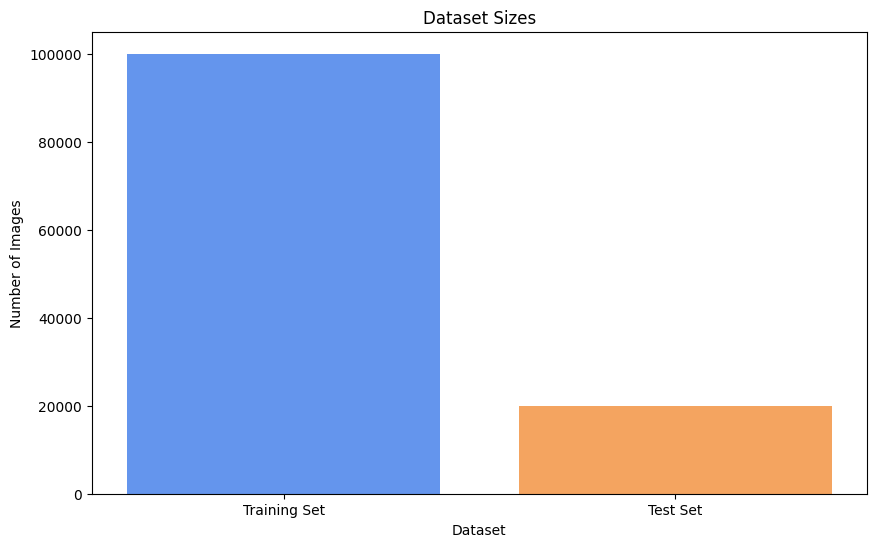

In [ ]:
# Plot graphs showing the sizes of the training and test sets
dataset_sizes = [len(train_set), len(test_set)]
dataset_labels = ['Training Set', 'Test Set']

plt.figure(figsize=(10, 6))
plt.bar(dataset_labels, dataset_sizes, color=['cornflowerblue', 'sandybrown'])
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Dataset Sizes')
plt.show()

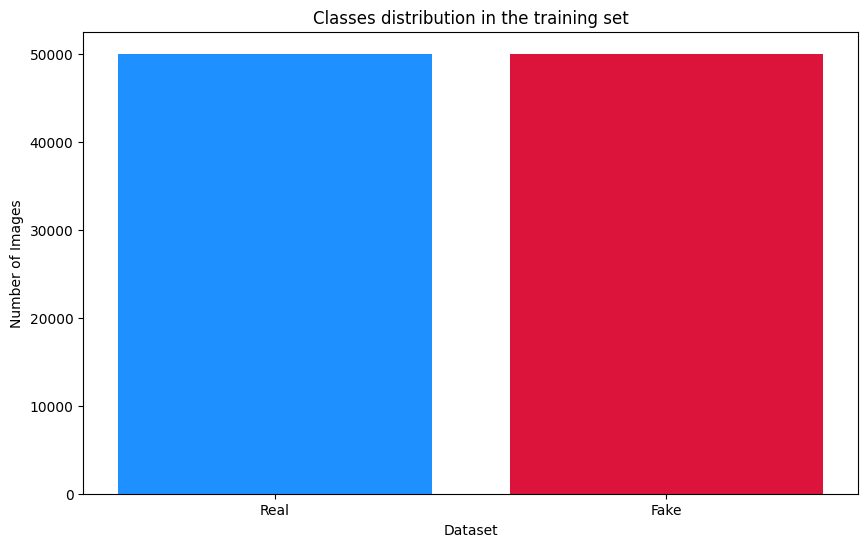

In [ ]:
# Observe the number of images for each class in testset
real_count_train = sum(label == 0 for label in train_set.targets)
fake_count_train = sum(label == 1 for label in train_set.targets)

# Define labels and counts
train_set_labels = ['Real', 'Fake']
train_counts = [real_count_train, fake_count_train]

plt.figure(figsize=(10, 6))
plt.bar(train_set_labels, train_counts, color=['dodgerblue', 'crimson'])
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Classes distribution in the training set')
plt.show()

We further split the training set into 80/20 training and validation sets, so that the test set can be used only for reporting at the end of the training.

### Data split

In [24]:
len_img=len(train_set)
len_train=int(0.8*len_img)
len_val=len_img-len_train

# Split Pytorch tensor
train_set,val_set=random_split(train_set,
                             [len_train,len_val]) # random split 80/20

print(f"Training set size: {len(train_set):,}")
print(f"Validation set size: {len(val_set):,}")
# TO-DO: Another graph now that we have a val set as well

Training set size: 80,000
Validation set size: 20,000


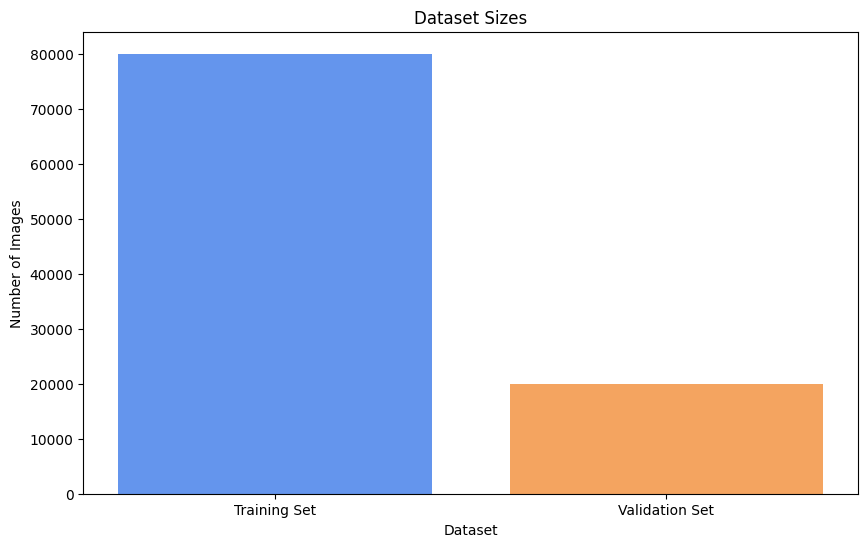

In [ ]:
# Plot graphs showing the sizes of the training and test sets
dataset_sizes = [len(train_set), len(val_set)]
dataset_labels = ['Training Set', 'Validation Set']

plt.figure(figsize=(10, 6))
plt.bar(dataset_labels, dataset_sizes, color=['cornflowerblue', 'sandybrown'])
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Dataset Sizes')
plt.show()

### Preprocessing

Applying transformations and visualizing them helps ensure that the data preprocessing and augmentation pipeline is correctly implemented before we start the training.
It also ensures that the transformations are enhancing the dataset in a way that will help the model generalize better to new / unseen data,
ultimately improving the model's performance and ensuring robustness.

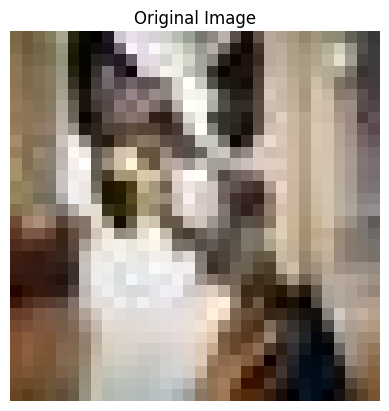

In [ ]:
img, label = val_set[3]

# Get an image and its label from the validation set
img, label = val_set[3]  # Index 3 is just an example; adjust as needed

# Convert PIL Image to numpy array
img_np = np.array(img)

# Transpose the image array to have the shape (height, width, channels)
img_np = np.transpose(img_np, (1, 2, 0))

# Visualize the original image
plt.imshow(img_np)
plt.axis('off')
plt.title("Original Image")
plt.show()

Augmentation techniques (e.g. random rotations, flips, color jittering) are typically applied only to the training set. The purpose of data augmentation is to artificially expand the training set and help the model generalize better by learning from varied examples. In other words, we don't want our model to fixate on irrelevant features like orientation, but capture the important ones instead. Augmentation should not be applied to the validation set because it should represent the true distribution of data the model will encounter in real-world scenarios - even if the data is synthetic!

For these reasons, we have used different kind of transformations for the training and validation set.

#### **Validation set**

*   **Resize**:

  All images have a uniform size, which is required for batch processing in neural networks

*   **Center crop**:

  We ensure that the center of the image is retained. This is a common practice to standardize input sizes for models like those in the ResNet family.

#### **Training set**
*Data augmentation*

*   **Random horizontal flip**:

  Flips the image horizontally with a probability of 0.5. This helps the model become invariant to the horizontal orientation of objects, increasing its robustness.

*   **Random rotation**:

  Rotates the image by up to 30 degrees randomly. This adds variation to the dataset, helping the model learn to recognize objects from different angles.

*   **Color jitter**:

  Randomly changes the brightness and contrast of the image, simulating different lighting conditions. This makes the model more robust to changes in lighting in real-world scenarios.

*   **Random channel permutation**:

  Randomly permutes the RGB channels, which can help the model become invariant to color variations. This is especially useful if color is not a crucial feature for classification.

*   **Normalization**:

  For each channel using the specified mean and standard deviation.

*  **Random Resized Crop**:

  This transformation is useful in data augmentation for tasks like image classification, where it introduces variations in the training data by randomly cropping and resizing images.Randomly crop a section of the image where the area of the crop varies between 80% and 100% of the original image's area.The cropped section is resized to a size of 32x32 pixels after cropping.


In [25]:
# Transform the training, validation and test sets
train_set.dataset.transform = transform_set(set_type='training')
val_set.dataset.transform = transform_set(set_type='validation')
test_set.transform = transform_set(set_type='validation')

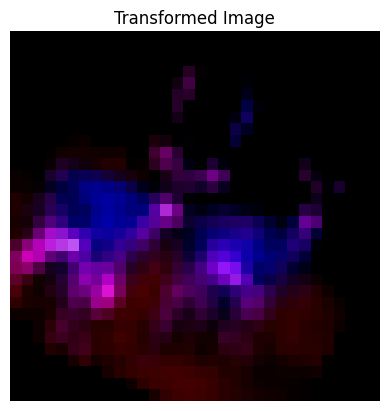

In [ ]:
img, label = train_set[3]

train_transformed_img = transform_set(set_type='training')

# Ensure 'img' is a PIL image for the transformation to work
img = transforms.ToPILImage()(img)

train_transformed_img = transform_set(set_type='training')(img)

# Convert the transformed image from PyTorch tensor to NumPy array
train_transformed_img_np = train_transformed_img.permute(1, 2, 0).numpy()

# Visualize the transformed image
plt.imshow(train_transformed_img_np)
plt.axis('off')
plt.title("Transformed Image from Training Set")
plt.show()

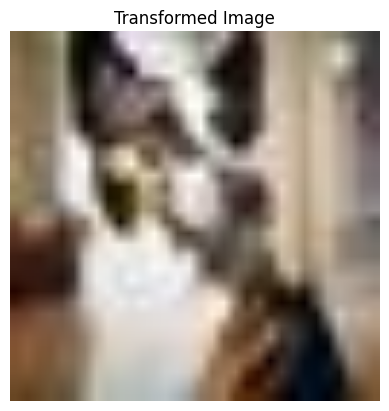

In [ ]:
# Get an image and label from the validation set
img, label = val_set[3]

# Ensure 'img' is a PIL image for the transformation to work
img = transforms.ToPILImage()(img)
val_transformed_img = transform_set(set_type='validation')(img)

# Convert the transformed image from PyTorch tensor to NumPy array
val_transformed_img_np = val_transformed_img.permute(1, 2, 0).numpy()

# Visualize the transformed image
plt.imshow(val_transformed_img_np)
plt.axis('off')
plt.title("Transformed Image from Validation Set")
plt.show()

## Training

In [26]:
# Utilise cuda if there's a GPU, otherwise perform the training on the CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


For the training we opted for 64 batches and shuffled the training and validation sets, without touching the test set.

In [27]:
# Batch size - change if we get an Out Of Memory error
batch_size = 64

# Training data loaders
train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True, # Shuffle for every epoch
    num_workers=2, pin_memory=True # Changed num_workers to 2 from 4 after warning
)
# Validation data loaders
val_loader = DataLoader(
    val_set, batch_size=batch_size, shuffle=False, # No need to shuffle the validation set
    num_workers=2, pin_memory=True
)

# Test data loaders
test_loader = DataLoader(
    test_set, batch_size=batch_size, shuffle=False, # No need to shuffle the test set
    num_workers=2, pin_memory=True
)

### Neural network architecture

We built our classifier with three convolutions layers (conv1, conv2, conv3) ending with 128 output channels, with ReLU activation functions, followed by max pooling layers (pool) and dropout. The fully connected layers (fc1, fc2, and fc3) process the output of the convolutional layers. We chose a kernel size of 3 and 1 padding.
We use Binary Cross Entropy loss which is appropriate for binary classification tasks like this one.

In [ ]:
model = ConvNet()
print(model)

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)


After multiple rounds of testing, we settled on these key training settings for optimizing our model. Throughout our training iterations, we continuously adjusted these parameters to improve the model's accuracy and efficiency. These settings were refined through systematic comparisons of different training runs, ensuring each adjustment contributed to enhancing the model's overall performance.

* **Weight Decay**: We introduced a small regularization effect with a weight decay of 1e-5. This addition came later in our process after noticing slight overfitting issues when the model didn't have this regularization.

* **Number of Epochs**: We chose to run the training for 20 epochs. This duration strikes a balance between allowing the model to learn adequately without risking overfitting or underfitting.

* **Patience**: To prevent unnecessary computations and overfitting, we set a patience of 5. If the validation loss doesn't improve over five consecutive epochs, training stops early.

* **Learning Rate**: We started with a learning rate of 0.001, a standard choice that helps the model learn effectively during the training process.

* **Learning Rate Scheduler**: We employed the ReduceLROnPlateau scheduler with a reduction factor of 0.1. This scheduler dynamically adjusts the learning rate downwards if the validation loss stops improving, allowing the model to fine-tune more effectively.


### Training

Epoch [1/20] - Learning Rate: 0.001000, Training Loss: 0.4341, Validation Loss: 0.3129, Training Accuracy: 0.7919, Validation Accuracy: 0.8664, Training F1: 0.7850, Validation F1: 0.8645
Saving model with validation loss: 0.3129
Epoch [2/20] - Learning Rate: 0.001000, Training Loss: 0.3037, Validation Loss: 0.2874, Training Accuracy: 0.8720, Validation Accuracy: 0.8856, Training F1: 0.8701, Validation F1: 0.8839
Saving model with validation loss: 0.2874
Epoch [3/20] - Learning Rate: 0.001000, Training Loss: 0.2506, Validation Loss: 0.2290, Training Accuracy: 0.8985, Validation Accuracy: 0.9098, Training F1: 0.8970, Validation F1: 0.9084
Saving model with validation loss: 0.2290
Epoch [4/20] - Learning Rate: 0.001000, Training Loss: 0.2203, Validation Loss: 0.2150, Training Accuracy: 0.9116, Validation Accuracy: 0.9173, Training F1: 0.9102, Validation F1: 0.9161
Saving model with validation loss: 0.2150
Epoch [5/20] - Learning Rate: 0.001000, Training Loss: 0.2056, Validation Loss: 0.19

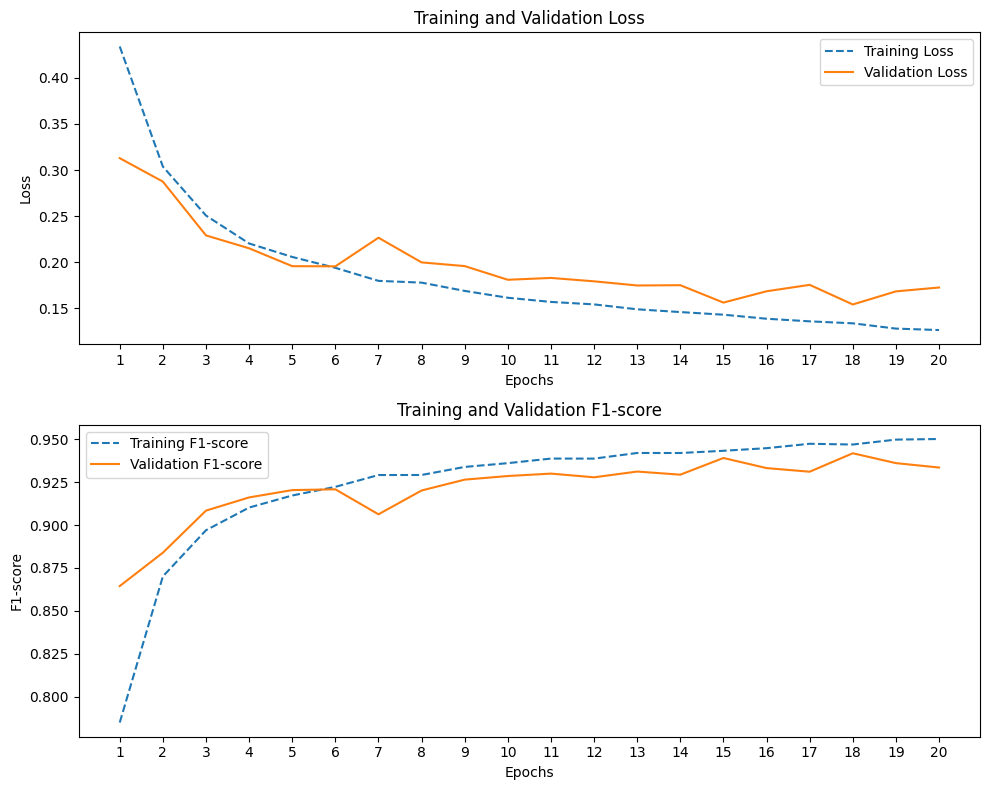

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
train_model(model=ConvNet(), train_loader=train_loader, val_loader=val_loader, criterion=nn.BCELoss())

**Total Iterations per Epoch**:

Given the training set size of 80,000 and a batch size of 64, the total number of iterations (mini-batches) per epoch is:

total_iterations = total_samples / batch_Size =
80000 / 64 = 1,250

**Printing Frequency**:

You want to balance between too frequent and too infrequent logging. If you print too often, it might clutter the output and slightly slow down training due to I/O operations. If you print too infrequently, you might not get enough information to monitor training effectively.
A common approach is to print the running loss a few times per epoch.

For an 80,000-sample training set and a batch size of 64, a good approach could be to print the loss every 200 mini-batches. This way, you'll get around 6 updates per epoch (1250 iterations / 200 = 6.25), which provides a good balance between feedback frequency and performance overhead.

### Evaluation

Test Loss: 0.6935, Test Accuracy: 0.5008, Test F1-score: 0.4998
Confusion Matrix:
[[    0 10000]
 [    0 10000]]


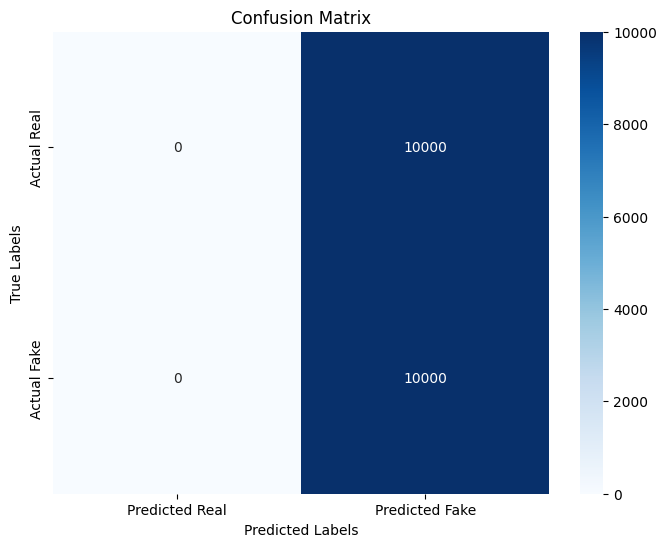


Classification Report:
              precision    recall  f1-score   support

        Real       0.00      0.00      0.00     10000
        Fake       0.50      1.00      0.67     10000

    accuracy                           0.50     20000
   macro avg       0.25      0.50      0.33     20000
weighted avg       0.25      0.50      0.33     20000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
# Evaluate a non-trained model with the same architecture
model = ConvNet()
evaluate_model(model, test_loader)

Test Loss: 0.1543, Test Accuracy: 0.9401, Test F1-score: 0.5003
Confusion Matrix:
[[9415  585]
 [ 612 9388]]


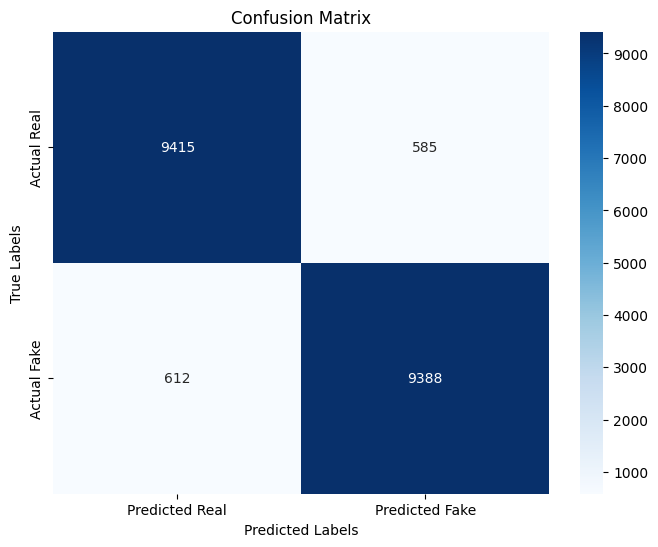


Classification Report:
              precision    recall  f1-score   support

        Real       0.94      0.94      0.94     10000
        Fake       0.94      0.94      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



In [28]:
# Evaluate the model on the test data
# Load the saved model
model = ConvNet()
model.load_state_dict(torch.load('./best_model_final.pth'))
evaluate_model(model, test_loader)

### Transfer learning

In [ ]:
# Get a set of pretrained model weights
weights = models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
model_pretrained = models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 85.6MB/s]


In [ ]:
# Get the transforms used to create our pretrained weights
pretrained_transforms = weights.transforms()
pretrained_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Create training and testing DataLoaders
batch_size = 64

# Train data loaders
train_set_tl = datasets.ImageFolder(root='train', transform= transform_set(set_type='training'))
train_loader_tl = DataLoader(
    train_set_tl,
    batch_size=batch_size
)
# Use initial test loader

# Test data loaders
test_set_tl = datasets.ImageFolder(root='test', transform=pretrained_transforms)
test_loader_tl = DataLoader(
    test_set_tl,
    batch_size=batch_size
)

In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
torchinfo.summary(model=model_pretrained,
        input_size=(32, 3, 32,32), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_pretrained.features.parameters():
    param.requires_grad = False

In [ ]:
# Get the length of class_names (one output unit for each class)
output_shape = 1

# Recreate the classifier layer and seed it to the target device
model_pretrained.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=1,
                    bias=True)).to(device)

In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
torchinfo.summary(model=model_pretrained,
        input_size=(32, 3, 32,32), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

In [ ]:
# Define loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_model(model=model_pretrained, train_loader=train_loader_tl, val_loader=test_loader_tl, criterion=loss_fn, n_epochs=20)

Epoch [1/20] - Learning Rate: 0.001000  Training Loss: 0.1357, Validation Loss: 18145.6327, Training Accuracy: 0.9576, Validation Accuracy: 0.5008, Training F1: 0.5937, Validation F1: 0.4998
Epoch [2/20] - Learning Rate: 0.001000  Training Loss: 0.1803, Validation Loss: 15539.1785, Training Accuracy: 0.9471, Validation Accuracy: 0.5008, Training F1: 0.5535, Validation F1: 0.4998
Epoch [3/20] - Learning Rate: 0.001000  Training Loss: 0.1778, Validation Loss: 12278.7081, Training Accuracy: 0.9473, Validation Accuracy: 0.5008, Training F1: 0.5504, Validation F1: 0.4998
Epoch [4/20] - Learning Rate: 0.001000  Training Loss: 0.1797, Validation Loss: 15839.1310, Training Accuracy: 0.9470, Validation Accuracy: 0.5008, Training F1: 0.5458, Validation F1: 0.4998
Epoch [5/20] - Learning Rate: 0.001000  Training Loss: 0.1790, Validation Loss: 17140.4115, Training Accuracy: 0.9468, Validation Accuracy: 0.5008, Training F1: 0.5454, Validation F1: 0.4998
Epoch [6/20] - Learning Rate: 0.001000  Train

# Demo

In [32]:
model = ConvNet()
state_dict = torch.load('/content/best_model_final.pth', map_location=device)
# state_dict = torch.load('/content/BestParameters/best_model.pth', map_location=device)
model.load_state_dict(state_dict)
model = model.eval()

In [33]:
real_dir = '/content/test/REAL'
fake_dir = '/content/test/FAKE'

real_images = [os.path.join(real_dir, img) for img in os.listdir(real_dir) if img.endswith(('png', 'jpg', 'jpeg'))]
fake_images = [os.path.join(fake_dir, img) for img in os.listdir(fake_dir) if img.endswith(('png', 'jpg', 'jpeg'))]

# Randomly select 10 images from each subfolder
real_samples = random.sample(real_images, 10)
fake_samples = random.sample(fake_images, 10)

# Combine the samples
examples = real_samples + fake_samples

def predict(input_image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    input_image = transform(input_image).unsqueeze(0)

    with torch.no_grad():
        prediction = model(input_image)
        confidence = torch.sigmoid(prediction).item()
        label = 'Fake' if confidence > 0.5 else 'Real'

    return label

In [34]:
gr.Interface(fn=predict,
             inputs=gr.Image(type="pil", height=256, width=256, show_download_button=True, show_label=True),
             outputs=gr.Textbox(),
             examples=examples).launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://70595b35739968fa5a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
